## Import functions

In [1]:
import gc
import seaborn as sns
import matplotlib.pyplot as plt

from src.loaders.data_loader import load_energy_efficiency_dataset
from src.transformers.data_transformer import transform_energy_efficiency_dataset

## Import dataset

In [2]:
features_df, targets_df = load_energy_efficiency_dataset()

In [3]:
features_df.sample(n=3, random_state=123)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
236,0.62,808.5,367.5,220.5,3.5,2.0,0.10,4.0
395,0.86,588.0,294.0,147.0,7.0,5.0,0.25,3.0
36,0.66,759.5,318.5,220.5,3.5,2.0,0.00,0.0


In [3]:
targets_df.sample(n=3, random_state=123)

,Heating_Load,Cooling_Load
236,12.85,14.37
395,29.07,29.82
36,7.18,12.40


## Feature engineering

In [4]:
data_dict = transform_energy_efficiency_dataset(
    features_df=features_df,
    targets_df=targets_df
)

In [5]:
scaled_train_features_df = data_dict["train"]["features"]
scaled_test_features_df = data_dict["test"]["features"]
scaled_val_features_df = data_dict["val"]["features"]

train_targets_df = data_dict["train"]["targets"]
test_targets_df = data_dict["test"]["targets"]
val_targets_df = data_dict["val"]["targets"]

In [6]:
del features_df, targets_df, data_dict
gc.collect()

17

## Data analysis

In [7]:
scaled_train_features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,460.0,1.042644e-15,1.001089,-1.394388,-0.737389,-0.080391,0.858179,1.984463
Surface_Area,460.0,-3.436864e-16,1.001089,-1.727019,-0.900350,-0.073681,0.752987,1.579656
Wall_Area,460.0,3.398248e-16,1.001089,-1.717485,-0.592068,-0.029359,0.533350,2.221477
Roof_Area,460.0,1.428809e-16,1.001089,-1.421729,-1.149117,-0.603894,1.031776,1.031776
Overall_Height,460.0,-3.089316e-17,1.001089,-1.062840,-1.062840,0.940875,0.940875,0.940875
Orientation,460.0,-1.814973e-16,1.001089,-1.347886,-0.451892,-0.451892,1.340095,1.340095
Glazing_Area,460.0,-1.641199e-16,1.001089,-1.843472,-1.073615,0.081170,1.235955,1.235955
Glazing_Area_Distribution,460.0,-7.337126e-17,1.001089,-1.870572,-0.575669,0.071783,0.719234,1.366686


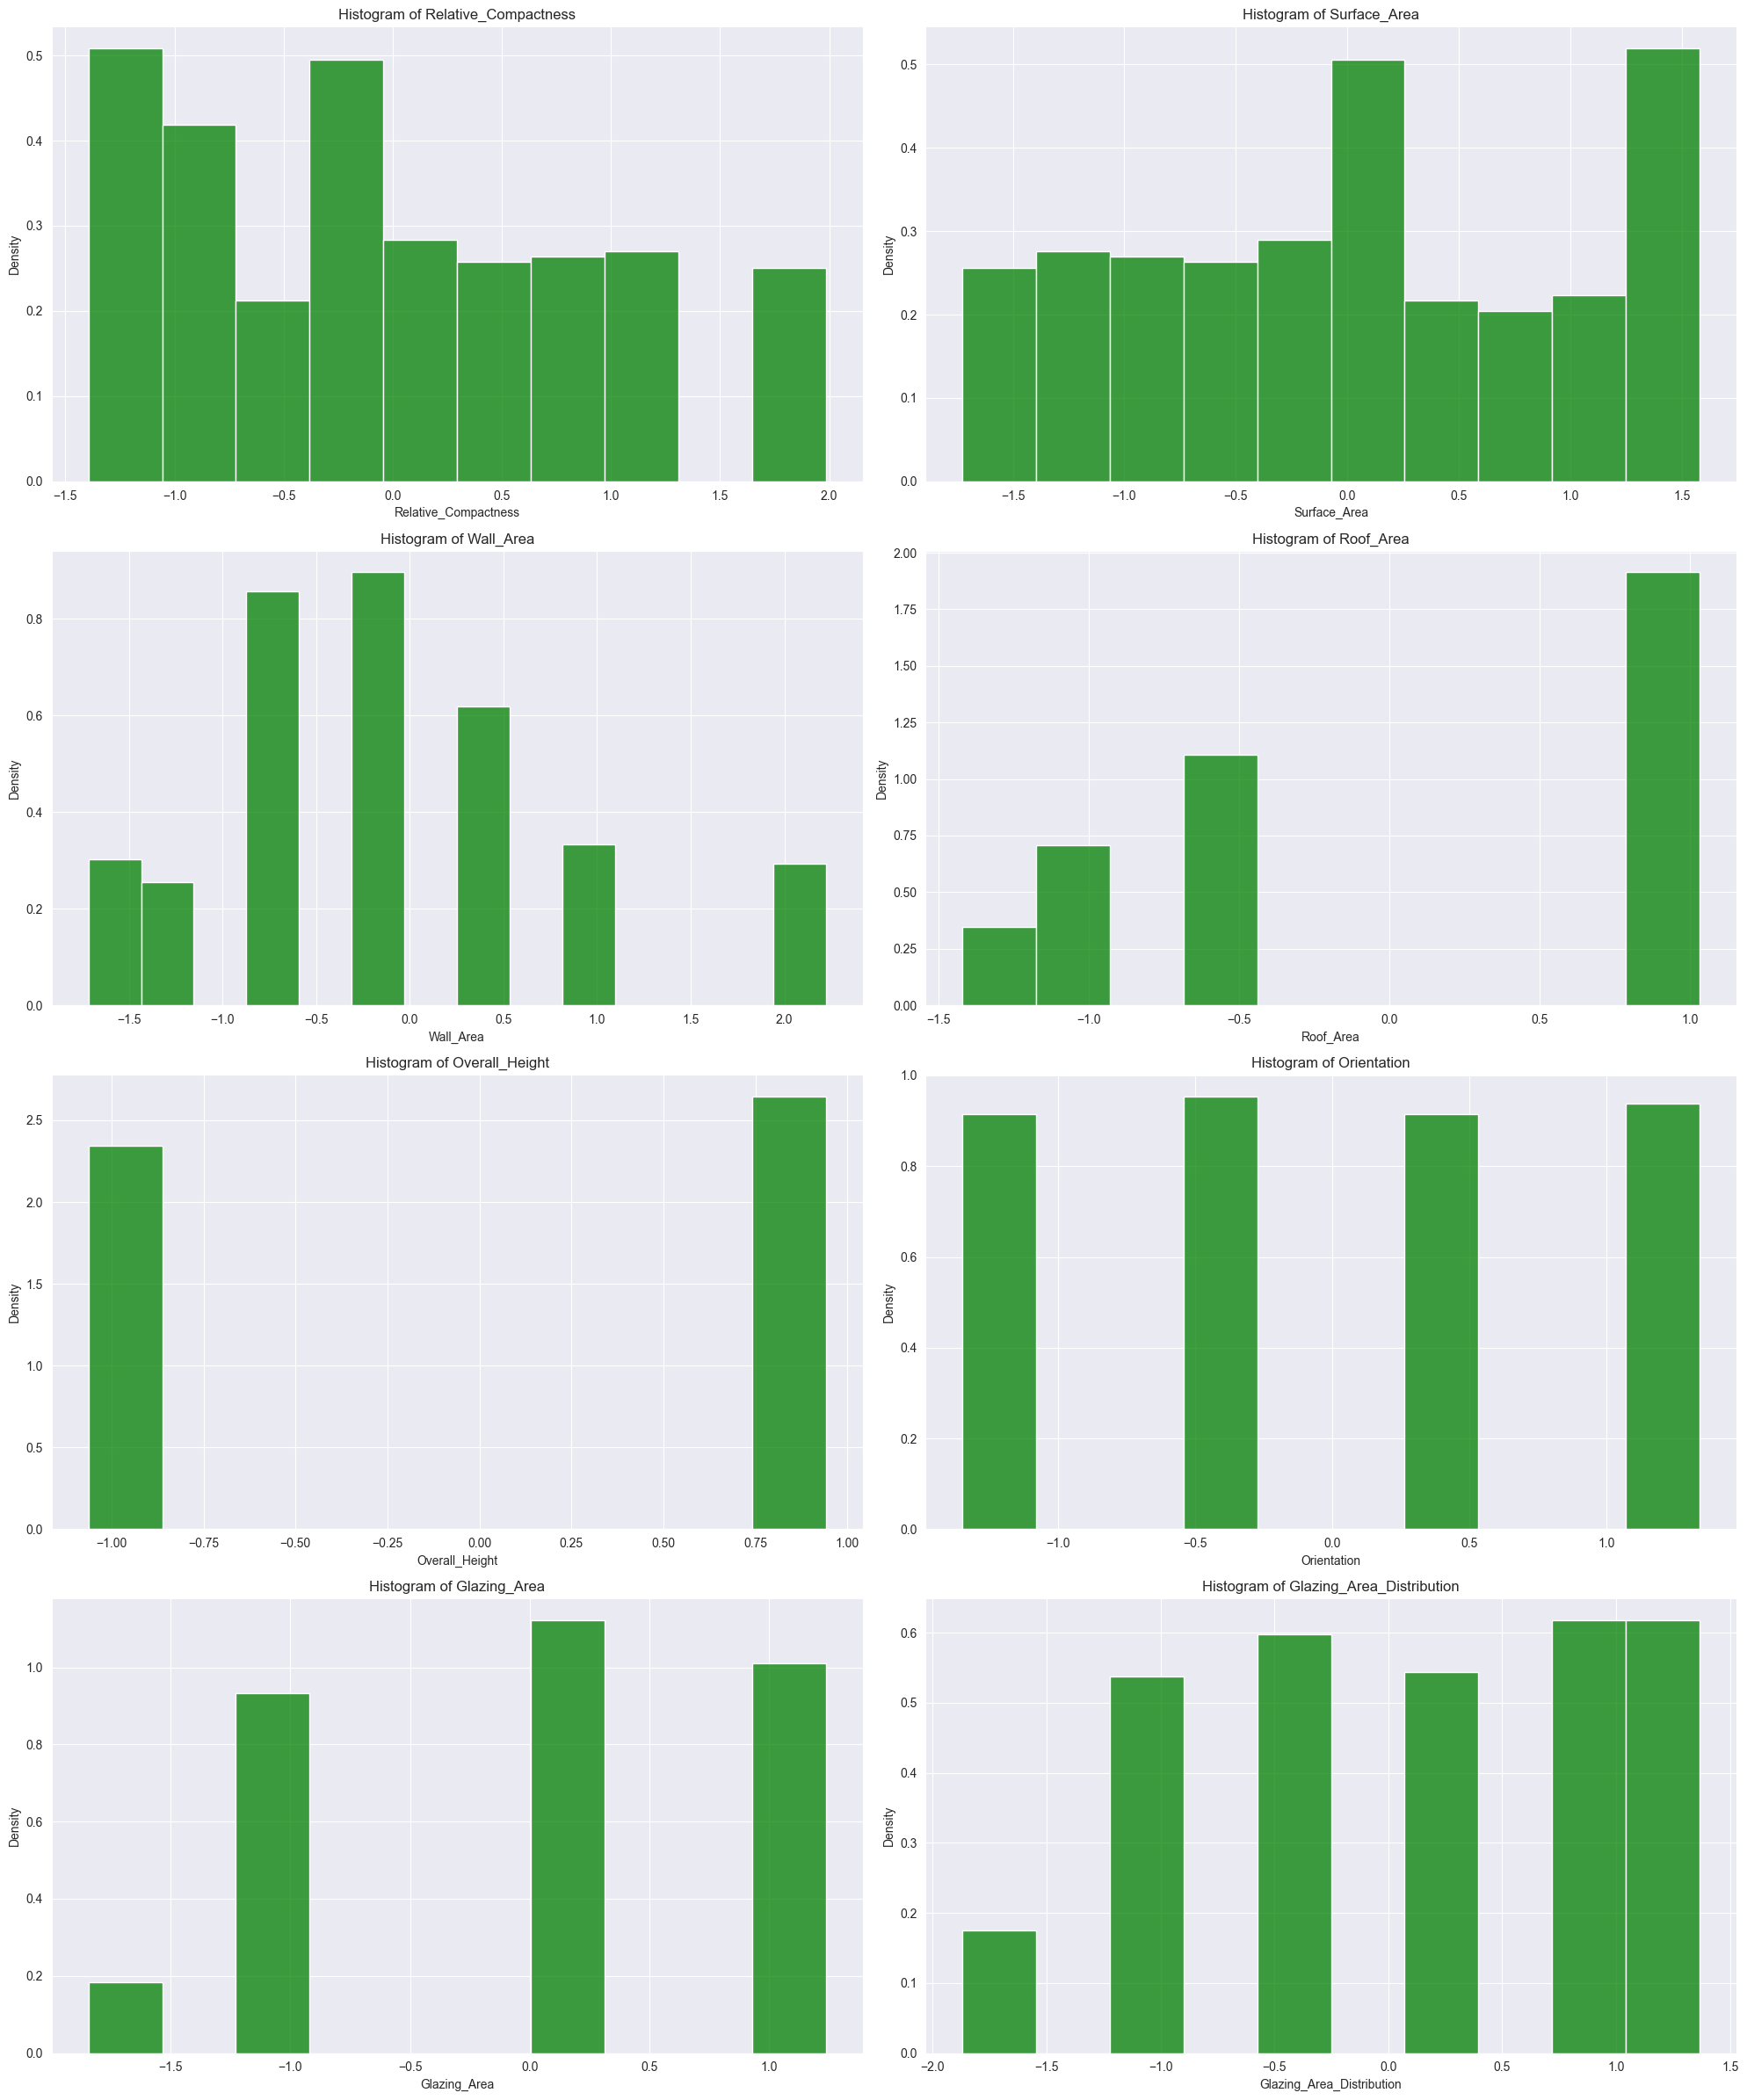

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

for i, column in enumerate(scaled_train_features_df.columns):
    row = i // 2
    col = i % 2

    sns.histplot(data=scaled_train_features_df, x=column, stat="density", color="green", ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [10]:
for feature in scaled_train_features_df.columns:
    print(f"Feature: {feature}, Number of unique values: {scaled_train_features_df[feature].nunique()}")

Feature: Relative_Compactness, Number of unique values: 12
Feature: Surface_Area, Number of unique values: 12
Feature: Wall_Area, Number of unique values: 7
Feature: Roof_Area, Number of unique values: 4
Feature: Overall_Height, Number of unique values: 2
Feature: Orientation, Number of unique values: 4
Feature: Glazing_Area, Number of unique values: 4
Feature: Glazing_Area_Distribution, Number of unique values: 6


Except Relative_Compactness and Roof_Area and Overall_Height, other features seems to have very few unique values. Converting them into categorical variables might be more beneficial.

In [9]:
for feature in scaled_train_features_df.columns:
    for target in train_targets_df.columns:
        print(f"Feature: {feature}, Target: {target}, Correlation: {scaled_train_features_df[feature].corr(train_targets_df[target])}")

Feature: Relative_Compactness, Target: Heating_Load, Correlation: 0.07921930743393119
Feature: Relative_Compactness, Target: Cooling_Load, Correlation: 0.07169734706798614
Feature: Surface_Area, Target: Heating_Load, Correlation: -0.08972234490950468
Feature: Surface_Area, Target: Cooling_Load, Correlation: -0.08075940073595521
Feature: Wall_Area, Target: Heating_Load, Correlation: 0.054689004280215635
Feature: Wall_Area, Target: Cooling_Load, Correlation: 0.07089159033294326
Feature: Roof_Area, Target: Heating_Load, Correlation: -0.11593049483827894
Feature: Roof_Area, Target: Cooling_Load, Correlation: -0.11507344295298517
Feature: Overall_Height, Target: Heating_Load, Correlation: 0.11982871294112644
Feature: Overall_Height, Target: Cooling_Load, Correlation: 0.11258950082401052
Feature: Orientation, Target: Heating_Load, Correlation: 0.030198499028819683
Feature: Orientation, Target: Cooling_Load, Correlation: 0.03439718687540943
Feature: Glazing_Area, Target: Heating_Load, Correla

The best linear correlation coefficient found among the features and targets is up to -11.6%, which is not very high. This suggests that the linear relationship between the features and the targets is not strong.

In [11]:
scaled_train_features_df.corr()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
Relative_Compactness,1.000000,-0.991693,-0.230954,-0.869207,0.825435,-0.035231,0.026396,0.015811
Surface_Area,-0.991693,1.000000,0.222671,0.881438,-0.857304,0.038626,-0.025610,-0.017982
Wall_Area,-0.230954,0.222671,1.000000,-0.264172,0.253125,0.041536,-0.029636,-0.012941
Roof_Area,-0.869207,0.881438,-0.264172,1.000000,-0.970772,0.018091,-0.010978,-0.011520
Overall_Height,0.825435,-0.857304,0.253125,-0.970772,1.000000,-0.019752,0.009142,0.011428
Orientation,-0.035231,0.038626,0.041536,0.018091,-0.019752,1.000000,0.030682,0.019827
Glazing_Area,0.026396,-0.025610,-0.029636,-0.010978,0.009142,0.030682,1.000000,0.252606
Glazing_Area_Distribution,0.015811,-0.017982,-0.012941,-0.011520,0.011428,0.019827,0.252606,1.000000


- Some features (such as Relative_Compactness, Surface_Area, Roof_Area and Overall_Height) are highly correlated linearly.
- They will need to be removed or transformed by doing a PCA, before computing a linear model.

## Linear models